<p style="text-align: center; font-size:200%;" size=10>
<span style="color:blue"> City of Tijuana, Metropolitan Transit System analysis</span> </p>
<p style="text-align: center; font-size:150%;" size=10> Transporte Vehicular Metropolitano (TVM) </p>

**Table of contents**:
1. [Libraries](#TVM_LIB).
2. [Experimental hyperparameters](#TVM_HP).
3. [Helper functions](#TVM_HELPER)
4. [Metrics](#TVM_METRICS). 
5. [Data analysis workflow](#TVM_WF).
6. [Data visualization](#TVM_VZ).
7. [Statistical data analysis](#TVM_SDT).
8. [References](#TVM_REF).

**Research tasks**:
- Research metric interpretation.

### <a name="TVM_LIB">1. <span style="color:blue">Libraries</span></a>

In [1]:
# Filter warnings
import warnings
warnings.filterwarnings('ignore')

In [32]:
import geojson
import pyproj                            # Utilities
from math import sin,cos,sqrt,asin,pi    # Utilities
from math import radians                 # Utilities
from decimal import *


import networkx as nx                    # Graph modelling see https://networkx.github.io/
import numpy as np
import json

import pandas as pd                      # Metrics
from abc import ABCMeta, abstractmethod  # Metrics


from sklearn.manifold import TSNE        # Statistical data analysis
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go

# from sklearn.cluster import DBSCAN       # Clustering
import hdbscan
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt          # Visualization
from matplotlib.pyplot import *
import seaborn as sns

%matplotlib inline

### <a name="TVM_HP">2. <span style="color:blue">Experimental hyperparameters</span></a>

The transport routes were edited with [JOSM](https://josm.openstreetmap.de/) Ver. 15238, an extensible editor for Open Street Map. The complete transportation network agregates 104 independent routes, with a total of 20,411 nodes. Routes share 80% of nodes, since they overlap and share intersections, reducing the node dataset to 4,461 unique nodes.  See Fig. 1. 
<br>
<img src="img/image.png" width="600" height="100">
<p style="text-align: center;">**Figure 1.** 104 routes at Tijuana transportation network.</p>
<br>
Six datasets are made available. Datasets with two, six, seven and twenty two routes were used for testing and simple data analysis and visualization. The complete transport network contains  104 independent routes. The  merged route dataset is used in the final analysis (104_routes.geojson). Datasets are in [geojson](https://geojson.org/) formated, an encoding format for geographic data structures. Dataset file names format is as follows ```<number of nodes>M,UM<merged or unmerged>R<number of polygons>P.geojson```.
<br>
<p style="text-align: center;">**Table I.** Tijuana transportation network datasets.</p>

| No. routes | No. polygons | dataset | 
|:--------:|:----------:|:------------|
| 2 | 0 | 2MR0P.geojson |
| 6 | 2 | 6MR2P.geojson |
| 7 | 0 | 7MR0P.geojson |
| 22 | 0 | 22MR0P.geojson |
| 104 | 0 | 104MR0P.geojson |

In [20]:
# hyperparameters   'ND','NDC','NiDC','NoDC','NBC','NCC','NLRC','NKC','NCCO','NCCW','KNN','KNNW'
# Node metrics centrality : 'ND','NDC','NiDC','NoDC','NBC','NCC','NLRC','NKC'
# Node metrics clustering : 'NCCO','NCCW','KNN','KNNW'
# Edge metrics:
# Global metrics: 'NLDA','NLD','NGRC','NLT'
hp = {                        #C:\Users\ahiralesc\Datasets\tvm\104MR0P.geojson
    "source_geojson"      : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P.geojson", # TODO: update with your path
    "node_metrics"        : ['ND','NDC','NiDC','NoDC','NBC','NCC','NLRC','NKC','NCCO','NCCW','KNN','KNNW'],
    "edge_metrics"        : [ ], #TODO:
    "global_metrics"      : ['NLDA','NLD','NGRC','NLT'], 
    "plot_node_metrics"   : ['ND','NDC','NiDC','NoDC','NBC','NCC','NLRC','NKC','NCCO','NCCW','KNN','KNNW'],
    "plot_edge_metrics"   : [ ], #TODO:
    "plot_global_metrics" : ['NLDA','NLD','NGRC','NLT'],
    "persistance"    : { "node_metrics"   : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_node_metrics.cvs",
                         "edge_metrics"   : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_edge_metrics.cvs",
                         "global_metrics" : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_global_metrics.cvs",
                         "dag"            : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_dag.pickle",
                         "node_tsne"      : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_node_tsne.cvs",
                         "edge_tsne"      : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_edge_tsne.cvs",
                         "node_clusters"  : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_node_clus.cvs",
                         "edge_clusters"  : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_edge_clus.cvs"
                       }
}

# Hiperparametros para la visualizacion
options = {
    'node_color' : 'yellow',
    'font_size'  : 7,
    'node_size' : 100,
    'edge_size' : 1,
    'width' : 1,
    'with_labels' : 'True'
}

### <a name="TVM_HELPER">3. <span style="color:blue">Helper functions</span></a>

In [4]:
class TVM_Helper:
    
    def __init__(self):
        pass
    
    
    def cargaRutas(self, trayectoriaArchivo):
        df = dict()
    
        # Carga de persistencia
        with open(trayectoriaArchivo) as f:
            rutas = geojson.load(f)
    
        # Determinar el numero de rutas en el archivo
        for r in range(len(rutas['features'])):
            ruta = rutas['features'][r]
            # Nombre de la ruta
            nombre_ruta = ruta["properties"]['name']
            # Extraer los puntos de cada ruta
            puntos   = ruta['geometry']['coordinates']
            dtype  = ruta['geometry']['type']
            df[nombre_ruta] = [puntos, dtype]
    
        return df


    def concatenaCoordenadas(self, tupla):
        return "%s:%s" % (tupla[1],tupla[0])


    
    def transformaRuta(self, ruta):
        l = list()
        for p in ruta:
            k = self.concatenaCoordenadas(p)
            l.append(k)
        return l


    def obtenVertices(self, df):
        vertices = pd.DataFrame(columns=['Tupla', 'Etiqueta', 'Longitud', 'Latitud'])
        vn = 0
        for k in df.keys():
            if df[k][1] == 'LineString':
                l = self.transformaRuta(df[k][0])
                for vertice in l:
                    if vertice not in vertices['Tupla'].unique():
                        etiqueta = "v%s" % (vn)
                        longitud = float(vertice.split(":")[1])
                        latitud  = float(vertice.split(":")[0])
                        vn = vn + 1
                        vertices = vertices.append({'Tupla' : vertice , 'Etiqueta' : etiqueta,
                                               'Longitud' : longitud, 'Latitud' : latitud} , ignore_index=True)
        # Hacer que la tupla sea el indice de la tabla
        vertices.set_index('Tupla',inplace=True)
        return vertices


    def distanciaEntrePuntos(self, o, d):
        name_ellps = "WGS84"
        geod = pyproj.Geod(ellps=name_ellps)

        lat1 = float(o.split(":")[0])
        long1 = float(o.split(":")[1])
        lat2 = float(d.split(":")[0])
        long2 = float(d.split(":")[1])
   
        grad1,grad2,distancia = geod.inv(long1, lat1, long2, lat2)
        return grad1, grad2, distancia


    def obtenAristas(self, df, vertices):
        # La distancia esta en metros (Dist)
        aristas = pd.DataFrame(columns=['Arista', 'Angulo1', 'Angulo2', 'Dist'])
        for k in df.keys():
            for i in range(len(df[k][0])-1):
                o = self.concatenaCoordenadas(df[k][0][i])
                d = self.concatenaCoordenadas(df[k][0][i+1])
                vo = vertices.loc[[o]]['Etiqueta'][0]
                vd = vertices.loc[[d]]['Etiqueta'][0]
                grad1, grad2, distancia = self.distanciaEntrePuntos(o,d)
                e = (vo,vd)
                aristas = aristas.append({'Arista' : e , 'Angulo1' : grad1, 'Angulo2' : grad2, 'Dist' : distancia} , ignore_index=True)
        return aristas 
    
    
    
    def obtenPoligonos(self, df):
        poligonos = pd.DataFrame(columns=['Nombre', 'Poligono'])
        vn = 0
        for k in df.keys():
            if df[k][1] == 'Polygon':
                poligonos = poligonos.append({'Nombre' : k , 'Poligono' : df[k][0][0]} , ignore_index=True)
        # Hacer que la tupla sea el indice de la tabla
        poligonos.set_index('Nombre',inplace=True)
        return poligonos


    
    def geodetic_a_geocentrica(self, ellipsoid, latitude, longitude, height):
        """ Return geocentric (Cartesian) Coordinates x, y, z corresponding to
            the geodetic coordinates given by latitude and longitude (in
            degrees) and height above ellipsoid. The ellipsoid must be
            specified by a pair (semi-major axis, reciprocal flattening).
            
            Autor: Gareth Rees
        """
        φ = radians(latitude)
        λ = radians(longitude)
        sin_φ = sin(φ)
        a, rf = ellipsoid           # semi-major axis, reciprocal flattening
        e2 = 1 - (1 - 1 / rf) ** 2  # eccentricity squared
        n = a / sqrt(1 - e2 * sin_φ ** 2) # prime vertical radius
        r = (n + height) * cos(φ)   # perpendicular distance from z axis
        x = r * cos(λ)
        y = r * sin(λ)
        z = (n * (1 - e2) + height) * sin_φ
        return x, y, z
        
        
    
    def extraccion_por_region(self, ruta_completa=True):
        from matplotlib import path

        # Parametros elipticos. Medidas en metros.
        WGS84 = 6378137, 298.257223563
        GRS80 = 6378137, 298.257222100882711
            
        # La altura promedio de Tijuama es 20m
        lat = float('43.21009')
        lon = float('-78.120123')
        h = float('20')
        
        # Iteracion sobre los poligonos
        for i, j in regions.iterrows():
            print(print(type(i)), print(type(j[0])))
    
        print(self.geodetic_a_geocentrica(WGS84, lat, lon, h))
        
        
        
        #p = path.Path([(0,0), (0, 1), (1, 1), (1, 0)])
        #flags = p.contains_points(np.hstack((xv.flatten()[:,np.newaxis],yv.flatten()[:,np.newaxis])))        

In [5]:
# tvm = TVM_Helper()
# tvm.extraccion_por_region()

In [6]:
# Data loading and preparation phase
#helper = TVM_Helper()
#routes = helper.cargaRutas(hp["source_geojson"])       # carga la bitacoras con las rutas
#nodes = helper.obtenVertices(routes)                   # prepara el marco con información de los nodos del grafo
#edges = helper.obtenAristas(routes, nodes)
#regions = helper.obtenPoligonos(routes)

### <a name="TVM_METRICS">4. <span style="color:blue">Metrics</span></a>


In [5]:
class Metrica(object):              # Clase abstracta que generaliza el concepto de criterio o metrica a aplicar
    
    def __init__(self):             
        self._nombre = None         # El nombre de la metrica
        self._tipo = None           # La clase de metrica a la que pertenece la metrica 
        
    def nombre(self):               # Obtiene el nombre de la metrica
        return self._nombre
    
    def tipo(self):                 # Obtene la clase a la que pertenece la metrica
        return self._tipo
    
    def __to_data_frame__(self, data):
        if isinstance(data, dict):
            pdf = pd.DataFrame(data, index=[0]).transpose()
            pdf.rename(columns={0: self._nombre}, inplace=True)
            pdf.index.name = "Etiqueta"
            return pdf
        if isinstance(data, nx.classes.reportviews.DiDegreeView):
            pdf = pd.DataFrame(dict(data), index=[0]).transpose()
            pdf.rename(columns={0: self._nombre}, inplace=True)
            pdf.index.name = "Etiqueta"
            return pdf
        if isinstance(data, (float, int)):
            pdf = pd.DataFrame([data], index=[0]).transpose()
            pdf.rename(columns={0: self._nombre}, inplace=True)
            return pdf
    
    def __concatenate__(self, pdf, ncol):
        return pd.concat([pdf, ncol], axis=1, join="inner")
    
    
    @abstractmethod
    def aplica(self, pdf, G):      # Aplica la metrica al grafo G y anexa una columna a la tabla pdf
        return None                # pass indica que no hace nada la metrica 

#### <a name="NCM">4.1. <span style="color:blue">Node centrality metrics</span></a>

Centrality metrics identify the most important nodes within the graph. Normalized values range between 0 and 1. A node with centrality value of 1, characterize it as an important vertex. Graph centrality metrics are summarized in Table II.  

1. The degree of a node $k_{i}$ is a number of edges adjacent to the node $i$, where  $j$ represents all other nodes, $a$ is the adjacency matrix, in which $a_{i,j}$ is defined as 1 if node $i$ is connected to node $j$, and 0 otherwise. Considering the order(degree) of the node, the higher the relevance it will have on the network since it implies connectivity since many links converge on it.

2. The degree centrality $C_i^{D}$ defines the proportion of nodes directly connected to the node with respect to all the nodes connected in the network, values are normalized by dividing by the maximum possible degree in a simple graph ${\left(V-1\right)}$. 

3. If a directed network is considered, then the degree can be extended to in-degree $k^{i}_{in}$ which calculate the number of links ending in.

4. The out-degree $k^{i}_{out}$ calculate the number of links starting from the node.

5. The Betweenness centrality $C_i^B$ is a fraction of all-pairs shortest paths that pass through node $i$, where ${n_{jh}\left(i\right)}$ is the number of the shortest paths between node j and h, which are passing through node $i$, while ${n_{jh}}$ is the number of all shortest paths between them. Kirkley[14] considers that it measures the importance of a node in terms of the amount of flow that passes through it, estimate the potential traffic that passes through each location in the graph.

6. The Closeness centrality $C_i^C$ calculates how far it is from a given node to all other nodes in a network, where $d_{ij}$ is the shortest path length between $i$ and $j$, indicates how close each of these locations is to all other surrounding locations within a given distance threshold.

7. The Local reaching centrality $C_{R}\left( i\right)$ measures the average weight of a given directed path starting from node $i$ in a weighted directed graph, where ${d^{out}\left( i,j\right) }$ is the length of the directed path that goes from $i$ and $j$ via out-going edges and ${w^{\left( k\right) }_{i}\left( j\right) }$ is the weight of the k-th edge along this path (link weight is assumed to be proportional to connection strength).
A higher weight implies a stronger connection between nodes and a shorter path length. The purpose of this measurement can be interpreted as an alternative to area density measurements, which explains the nodes that can be accessed along a modeled network.

8. Katz centrality $x_i$ is the generalization of the eigenvector centrality,  where $\alpha$ is the attenuation factor, neighbors $x_j$  and extra weight can be provided to immediate neighbors through the parameter $\beta$, both are positive constants.

9. The weight and strength $s_i$ where $w_{ij}$ describes the weight of the edge between $i$ and $j$ and $V$ represents the neighbor set of node $i$. For real transport systems, the weight can be traffic flow, travel time, geographical distance or similar of the link. For a directed network, the intensity and external resistance of a node respectively estimate the weights of the edges entering or leaving it.

10. The Straightness centrality $C^{S}_{i}$ is an important measure for navigating transport networks, where ${d^{Eucl}_{ij}}$ represents the Euclidean distance between $i$ and $j$.

<p style="text-align: center;">**Table II.** Node centrality.</p>

|#| Metric | Expression | Interpretation | Ref. | Label |
|:---:|:---------------------|:---------------------------------------|:-------|:---:|:----|
|1| [Degree](https://networkx.github.io/documentation/networkx-2.2/reference/classes/generated/networkx.Graph.degree.html) | $k_i=\sum _{j}a_{ij}.$ | Number of edges adjacent to the node | [4,7,5] | ND | 
|2| [Degree centrality](https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.algorithms.centrality.degree_centrality.html) | $C_i^{D}=\frac{\sum_{j} a_{i,j}}{\left(V-1\right)}$ | The fraction of nodes it is connected to. | [10,5] | NDC |
|3| [InDegree centrality](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.centrality.in_degree_centrality.html#networkx.algorithms.centrality.in_degree_centrality) | $k^{i}_{in}=\sum _{j\in V}a_{ji},$ | Fraction of node incoming edges connected to a node | [19] | NiDC | 
|4| [OutDegree centrality](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.centrality.out_degree_centrality.html#networkx.algorithms.centrality.out_degree_centrality) | $k^{i}_{out}=\sum _{j\in V}a_{ij}.$  | Fraction of node outgoing edges connected to a node| [19] | NoDC | 
|5| [Betweenness centrality](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality) | $C_i^B=\sum_{j,h\in V;j\neq h}\frac{n_{jh}\left(i\right)}{n_{jh}}$ |  Level of intermediate importance of a node in the interaction between other nodes  | [19,11,16,5,6] |NBC|
|6| [Closeness centrality](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality) | $C_i^C=\frac{1}{\sum_{j\in V;i\neq j}\ d_{ij}}$ | The reciprocal of the average shortest path distance to u over all n-1 reachable nodes.| [3,10,11,16,6] | NCC |
|7| [Local reaching centrality](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.centrality.local_reaching_centrality.html#networkx.algorithms.centrality.local_reaching_centrality) | $C_{R}\left( i\right) =\dfrac {1}{v-1}\sum _{j:0 <d^{out}\left( i,j\right) <\infty }\left( \dfrac {\sum ^{d^{out}\left( i,j\right) }_{k=1}w^{\left( k\right) }_{i}\left( j\right) }{d^{out}\left( i,j\right) }\right)$ | The proportion of other nodes reachable from that node | [20] | NLRC |
|8| [Katz centrality](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.katz_centrality.html)| $x_i = \alpha \sum_{j} a_{ij} x_j + \beta$ | The centrality of a node is based on the centrality of its neighbors | [6] | NKC |
|9| Weight and Strength | $s_i=\sum _{j\in V}w_{ij}.$ | Strength of nodes in terms of the total weight of their connections | [18] | NWS | 
|10| Straightness centrality | $C^{S}_{i}=\sum _{j\neq i}\dfrac {d^{Eucl}_{ij}}{d_{ij}},$ | Number of times a node is present in the shortest path between 2 other nodes| [19,4,5] |NSC|

In [6]:
class Node_Degree(Metrica): 
    """
        II.1. The node degree is the number of edges adjacent to the node.
    """
    def __init__(self):
        self._nombre = "ND"
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = nx.degree(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf

    

class Node_Degree_centrality(Metrica):                         
    """
        II.2. The degree centrality for a node v is the fraction of nodes it is connected to.
    """
    def __init__(self):
        self._nombre = "NDC" 
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = nx.degree_centrality(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf


    
class Node_Indegree_centrality(Metrica):                         
    """
        II.3. The fraction of node incoming edges connected to a node.
    """
    def __init__(self):
        self._nombre = "NiDC" 
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = nx.in_degree_centrality(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf    

    
    
class Node_Outdegree_centrality(Metrica):                         
    """
        II.4. The fraction of node outgoing edges connected to a node.
    """
    def __init__(self):
        self._nombre = "NoDC" 
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = nx.out_degree_centrality(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf    
    
    
class Node_Betweeness_centrality(Metrica):
    """
        II.5. The sum of the fraction of all-pairs shortest paths that pass through v
    """
    def __init__(self):
        self._nombre = "NBC" 
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = nx.betweenness_centrality(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf


class Node_Closeness_centrality(Metrica):
    """
        II.6. The reciprocal of the average shortest path distance to u over all n-1 reachable nodes
    """
    def __init__(self):
        self._nombre = "NCC" 
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = nx.katz_centrality(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf    


class Node_Local_reaching_centrality(Metrica):
    """
        II.7. The proportion of other nodes reachable from that node
    """
    def __init__(self):
        self._nombre = "NLRC" 
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = dict()
        for node in pdf.index:
            data.update( {str(node) : nx.local_reaching_centrality(G,node)} )
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf   
    
    
class Node_Katz_centrality(Metrica):
    """
        II.8. The centrality of a node is based on the centrality of its neighbors
    """
    def __init__(self):
        self._nombre = "NKC" 
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = nx.katz_centrality(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf

#### <a name="NCM">4.2. <span style="color:blue">Node clustering</span></a>

Graph clustering metrics are summarized in Table III.  

1. The Clustering coefficient $C\left(i\right)$ for unweighted graphs, deﬁned as the number of triangles in which node $i$ participates normalized by the maximum possible number of such triangles, since each triangle contains three nodes, where ${T_i}$ denotes the number of triangles around $i$. Hence $C\left(i\right)\mathrm{= 1}$  if all of the neighbors are connected and 0 otherwise. A clustering coefficient measures how influential node $i$ is, taking lower values the more structural holes in the network around $i$. This can be bad when  are interested in the efficient diffusion of traffic around a network, since they reduce the number of alternative routes that can be done through the network.

2. The Clustering coefficient weighted $C\left( i\right) _{w}$ as the probability that two neighbors of a node are likely to be connected themselves for directed graph, where $k_i^{tot}$ is the sum of in-degree and out-degree of $i$ and $k_i^{\leftrightarrow}$ is the reciprocal degree of $i$. 

3. The $k_{nn,i}$ Average nearest-neighbors degree of $i$, in which $N(i)$ are the neighbors of node $i$.

4. The Weighted average nearest-neighbors degree $k^{w}_{nn,i}$ measures the effective affinity to connect with high-or low degree neighbors according to the magnitude of the actual interactions

<p style="text-align: center;">**Table III.** Node clustering.</p>

|#| Measure | Expression | Interpretation | Ref. | Label |
|:--:|:---------------------|:---------------------------------------|:-------|:---:|:----|
| 1 | [Clustering coefficient](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html#networkx.algorithms.cluster.clustering) | $C\left(i\right)\mathrm{=}\frac{\mathrm{2}T_i}{\left.k_i\mathrm{(}k_i\mathrm{-}\mathrm{1}\right)}$, |  The density of triangles in the networks | [21,9,3,5,6] | NCCO|  
| 2| [Clustering coeff. weighted](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html#networkx.algorithms.cluster.clustering) | $C\left( i\right) _{w}= \frac{1}{k_i^{tot}(k_i^{tot}-1) - 2k_i^{\leftrightarrow}}T_i,$ |  Fraction of all possible directed triangles of the subgraph edge weights | [18] | NCCW|
|3 | [(knn)](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.assortativity.average_neighbor_degree.html#networkx.algorithms.assortativity.average_neighbor_degree) | $k_{nn,i}=\dfrac {1}{\left| N\left( i\right) \right| }\sum _{j\in N\left( i\right) }k_{j}$ | Neighbor connectivity is the correlation between the degree of nodes and the average degree of their neighbors | [18] | KNN |
|4 | [(knn) wighted](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.assortativity.k_nearest_neighbors.html#networkx.algorithms.assortativity.k_nearest_neighbors) | $k^{w}_{nn,i}=\dfrac {1}{s_{i}}\sum _{j\in N\left( i\right) }w_{ij}k_{j}$ | Weighted average nearest-neighbors degree | [18] | KNNW|


In [7]:
class Node_Clustering_Coefficient(Metrica):
    """
    III.1. The fraction of all possible directed triangles or geometric average of the subgraph edge 
        weights for unweighted and weighted directed graph respectively
    OPTIONS: clustering(G, nodes=None, weight=None)

    """
    def __init__(self):
        self._nombre = "NCCO" 
        self._tipo = "Node connectivity"
    
    
    def aplica(self, pdf, G):
        data = nx.clustering(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf
    
    
class Node_Clustering_Coefficient_Weighted(Metrica):
    """
    III.2. The fraction of all possible directed triangles of the subgraph edge weights

    """
    def __init__(self):
        self._nombre = "NCCW" 
        self._tipo = "Node connectivity"
    
    
    def aplica(self, pdf, G):
        data = nx.clustering(G, weight = 'weight')
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf
    

class Node_knn(Metrica):
    """
    III.3.  Neighbor connectivity is the correlation between the degree of nodes and the average degree of their neighbors
    OPTIONS: average_neighbor_degree(G, source='out', target='out', nodes=None, weight=None)
    """
    def __init__(self):
        self._nombre = "KNN" 
        self._tipo = "Node connectivity"
    
    
    def aplica(self, pdf, G):
        data = nx.average_neighbor_degree(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf

    
    
class Node_knn_weighted(Metrica):
    """
    III.4.  Weighted average nearest-neighbors degree

    """
    def __init__(self):
        self._nombre = "KNNW" 
        self._tipo = "Node connectivity"
    
    
    def aplica(self, pdf, G):
        data = nx.average_neighbor_degree(G, weight='weight')
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf 

#### <a name="NCM">4.3. <span style="color:blue">Network level properties</span></a>

Some metrics at network level are summarized in Table IV.

1. The Degree Assortativity coefficient $K_{nn}\left( i\right)$ measures the similarity of connections in the graph with respect to the node degree, in which $k_j$ is the degree of node $j$. In a network, if a node with a high degree value intends to be connected with other high-degree nodes, then assortativity is detected, otherwise it is regarded as disassortativity. The network is asortative, if a significant number of edges run through nodes of the same type or similar characteristics.

2. Diameter $\mathrm{\delta }(G)$ as a maximum number of edges in the shortest path between each pair of nodes, where $d$ is the topological length. A higher connectivity, have lower diameter values. In the case of a complex graph, the diameter can be found with a topological distance matrix (Shimbel distance), which computes for each node pair its minimal topological distance.  

3. The Global Reaching Centrality for unweighted directed graphs is the average over all nodes of the difference between the local reaching centrality of the node and the greatest local reaching centrality of any node in the network $GRC$ where $C_{R}\left( i\right)$ is the number of nodes with a finite positive directed distance from node i divided by ${V-1}$, i.e., the maximum possible number of nodes reachable from a given node, and $C^{\max }_{R}$ denote the highest local reaching centrality and define.

4. The Transitivity $T(G)$ of the network, is similar to calculate the average clustering coefficient for all nodes in the network, where the number of triangles in the network is deﬁned as $δ(G)$ and  triplets (possible triangles,chains of nodes) have been termed 2-path as they
form chains of two directed ties between three nodes are defined as $\tau{(G)}$  in the network. A path $h-i-j$ of length two from a digraph is transitive if vertex $h$ is connected to vertex $j$. Hence $0 \leq T \leq 1$ for $T=1$ as a completely connected network. 

5. The longest path lenght...

6. A simple indicator of a graph is the Average degree $\langle k\rangle$ denote the average over the nodes of the network where $E$ and $V$ represents respectively the number of the edges and nodes.

7. The Number of Cycles $\mathrm{\textrm{µ}}$ as the maximum number of independent cycles in a network, where $P$ is the number of non-connected subgraph. Trees and simple networks have a value of 0 since they have no cycles. The more complex a network is, the higher the value of $\mathrm{\textrm{µ}}$, so it can be used as an indicator of the level of development and complexity of a transport system. 


<br>
<p style="text-align: center;">**Table IV.**  Network level properties</p>

|#| Measure | Expression | Interpretation | Ref. | Label |
|:--:|:---------------------|:---------------------------------------|:-------|:---:|:----| 
|1| [Degree assortativity coefficient](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.assortativity.degree_assortativity_coefficient.html)| $k_{nn}\left( i\right)=\dfrac {1}{k_{i}}\sum _{j\in V}k_{j}$ | the similarity of connections in the graph with respect to the node degree | [17,5,6] |NLDA|
|2| [Diameter](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html?highlight=diameter#networkx.algorithms.distance_measures.diameter)  | $\mathrm{\delta }$(G) = ${}_{i\ }$max${}_{j}$ d(i,j)     | The length of the longest path of the network | [7,15] |NLD|
|3| [Global reaching centrality](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.centrality.global_reaching_centrality.html#networkx.algorithms.centrality.global_reaching_centrality) | $GRC=\dfrac {\sum _{i\in V}\left[ C^{\max }_{R}-C_{R}\left( i\right) \right] }{V-1}$  | The average over all nodes of the difference between the local reaching centrality of the node and the greatest local reaching centrality of any node in the network  | [20] |NGRC|
|4| [Transitivity](https://networkx.github.io/documentation/networkx-2.2/reference/algorithms/generated/networkx.algorithms.cluster.transitivity.html#networkx.algorithms.cluster.transitivity)  | $T\left(G\right) =\dfrac {3\delta \left( G\right) }{\tau \left( G\right) }$ |  Probability for the network to have adjacent nodes interconnected as possible triangles in the network | [23,24,17] |NLT|
|5| [Longest path lenght](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.dag.dag_longest_path_length.html#networkx.algorithms.dag.dag_longest_path_length) | EQUATION TODO | The longest path lenght | [TODO]| LPL |
|6| Average Degree | $\langle k\rangle =\dfrac {2E}{V}$ | Measures the accessibility of the whole network | [4,5,18] |NLAD|
|7| Number of Cycles | $\mathrm{\textrm{µ}=}E\mathrm{-}V\mathrm{+}P$ | The max number of independent or fundamental circuits in the network | [7,15] |NLNC|



In [8]:
class Assortativity_Network(Metrica):
    """
    IV.1.  Rations among similar nodes in the network
    OPTIONS: degree_assortativity_coefficient(G, x='out', y='in', weight=None, nodes=None)

    """
    def __init__(self):
        self._nombre = "NLDA" 
        self._tipo = "Network level"
    
    
    def aplica(self, pdf, G):
        data = nx.degree_assortativity_coefficient(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf

    
class Diameter_Network(Metrica):
    """
    IV.2.  The length of the longest path of the network
    adjacent nodes interconnected as possible triangles in the network
    OPTIONS: diameter(G, e=None, usebounds=False)

    """
    def __init__(self):
        self._nombre = "NLD" 
        self._tipo = "Network level"
    
    
    def aplica(self, pdf, G):
        data = nx.diameter(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf

    
class Global_reaching_centrality(Metrica):
    """
    IV.3.  The average over all nodes of the difference between the
    local reaching centrality of the node and the greatest local 
    reaching centrality of any node in the network
    OPTIONS: global_reaching_centrality(G, weight=None, normalized=True)

    """
    def __init__(self):
        self._nombre = "NGRC" 
        self._tipo = "Network level"
    
    
    def aplica(self, pdf, G):
        data = nx.global_reaching_centrality(G, weight=None, normalized=True)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf


class Transitivity_Network(Metrica):
    """
    IV.4.  Probability for the network to have 
    adjacent nodes interconnected as possible triangles in the network

    """
    def __init__(self):
        self._nombre = "NLT" 
        self._tipo = "Network level"
    
    
    def aplica(self, pdf, G):
        data = nx.transitivity(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf

    
class DAG_Longest_path_lenght(Metrica):
    """
    IV.5. The longest path lenght in a DAG

    """
    def __init__(self):
        self._nombre = "LPL" 
        self._tipo = "Network level"
    
    
    def aplica(self, pdf, G):
        data = nx.dag_longest_path_length(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf

In [9]:
# Filter factory
class MetricFactory:
    
    def create(self, atype):  
        auto = {
            'ND'  : Node_Degree(),
            'NDC' : Node_Degree_centrality(),
            'NiDC' : Node_Indegree_centrality(),
            'NoDC' : Node_Outdegree_centrality(),
            'NBC' : Node_Betweeness_centrality(),
            'NCC' : Node_Closeness_centrality(),
            'NLRC': Node_Local_reaching_centrality(),
            'NKC' : Node_Katz_centrality(),
            'NCCO' : Node_Clustering_Coefficient(),
            'NCCW': Node_Clustering_Coefficient_Weighted(),
            'KNN'  : Node_knn(),
            'KNNW' : Node_knn_weighted(),
            'NLDA' : Assortativity_Network(),
            'NLD'  : Diameter_Network(),
            'NGRC' : Global_reaching_centrality(),
            'NLT'  : Transitivity_Network(),
            'LPL'  : DAG_Longest_path_lenght()
        }[atype]
        return auto

### <a name="TVM_WF">5. <span style="color:blue">Data analysis workflow</span></a>

In [21]:
# Data loading and preparation phase
helper = TVM_Helper()
routes = helper.cargaRutas(hp["source_geojson"])       # carga la bitacoras con las rutas
nodes = helper.obtenVertices(routes)                   # prepara el marco con información de los nodos del grafo
edges = helper.obtenAristas(routes, nodes)             # prepara el marco con información de las aristas del grafo
nodes = nodes.reset_index()                            # Para restaurar el indice original en la tabla de nodos
nodes = nodes.set_index('Etiqueta')
dagprop =  pdf = pd.DataFrame(['0'])

In [11]:
# Graph preparation phase
G = nx.DiGraph()                                       # un grafo dirigido vacio es creado
for node in nodes.index:                               # el conjunto de vertices es anexado al grado
    G.add_node(node)
for index, linea in edges.iterrows():                  # el conjunto de aristas dirigidas es anexado al grafo
    G.add_edge(linea['Arista'][0], linea['Arista'][1], weight=linea['Dist'])

In [22]:
# Filter selecction phase 
metrics_factory = MetricFactory()
nmetrics = dict()  # node metrics
emetrics = dict()  # edge metrics
gmetrics = dict()  # glocal metrics

if(len(hp["node_metrics"])>0):
    for metric_name in hp["node_metrics"]:
        nmetrics[metric_name] = metrics_factory.create(metric_name)

if(len(hp["edge_metrics"])>0):
    for metric_name in hp["edge_metrics"]:
        emetrics[metric_name] = metrics_factory.create(metric_name)

if(len(hp["global_metrics"])>0):
    for metric_name in hp["global_metrics"]:
        gmetrics[metric_name] = metrics_factory.create(metric_name)

In [23]:
# Metric aplication phase
if(len(hp["node_metrics"])>0):
    for _name, _metric in nmetrics.items():
        nodes = _metric.aplica(nodes, G)

if(len(hp["edge_metrics"])>0):
    for _name, _metric in emetrics.items():
        edges = _metric.aplica(edges, G)

if(len(hp["global_metrics"])>0):
    for _name, _metric in gmetrics.items():
        dagprop = _metric.aplica(dagprop, G)
    dagprop = dagprop.drop([0], axis=1)

In [24]:
# To persistance in CSV format
nodes.to_csv(hp["persistance"]["node_metrics"], index=True,  encoding="ISO-8859-1")
edges.to_csv(hp["persistance"]["edge_metrics"], index=True,  encoding="ISO-8859-1")
dagprop.to_csv(hp["persistance"]["global_metrics"], index=True,  encoding="ISO-8859-1")
nx.write_gpickle(G, hp["persistance"]["dag"])

### <a name="TVM_VZ">6. <span style="color:blue">Data visualization</span></a>

In [5]:
# Load from persistance
nodes = pd.read_csv(hp["persistance"]["node_metrics"],  keep_default_na=False, sep=",", index_col=0, encoding ="ISO-8859-1", engine='python')
edges = pd.read_csv(hp["persistance"]["edge_metrics"],  keep_default_na=False, sep=",",  index_col=0, encoding ="ISO-8859-1", engine='python')
dagprop = pd.read_csv(hp["persistance"]["global_metrics"],  keep_default_na=False, sep=",",  index_col=0, encoding ="ISO-8859-1", engine='python')
G = nx.read_gpickle(hp["persistance"]["dag"])

#### <a name="TVM_GDP">6.1 <span style="color:blue">Global properties.</span></a>

Overall neighborhood density among nodes is of 0.011, thus tightly connected communities occur. The transport netwok contains 20 cycles.

In [26]:
# Output DAG global properties
dagprop

,NLDA,NLD,NGRC,NLT
0,0.374068,190,0.0,0.011096


#### <a name="TVM_VZ">6.2 <span style="color:blue">Node properties.</span></a>


In [27]:
nodes.describe()

,Longitud,Latitud,ND,NDC,NiDC,NoDC,NBC,NCC,NLRC,NKC,NCCO,NCCW,KNN,KNNW
count,4461.000000,4461.000000,4461.000000,4461.000000,4461.000000,4461.000000,4461.000000,4461.000000,4461.0,4461.000000,4461.000000,4461.000000,4461.000000,4461.000000
mean,-116.954369,32.487615,3.092132,0.000693,0.000347,0.000347,0.013893,0.014929,1.0,0.014929,0.005493,0.000195,1.653135,1.655363
std,0.087044,0.037903,1.281389,0.000287,0.000150,0.000150,0.019221,0.001131,0.0,0.001131,0.041488,0.002774,0.680800,0.699021
min,-117.121511,32.373005,2.000000,0.000448,0.000224,0.000224,0.000000,0.013952,1.0,0.013952,0.000000,0.000000,1.000000,1.000000
25%,-117.023280,32.464383,2.000000,0.000448,0.000224,0.000224,0.002642,0.013953,1.0,0.013953,0.000000,0.000000,1.000000,1.000000
50%,-116.959913,32.492859,3.000000,0.000673,0.000224,0.000224,0.005969,0.014140,1.0,0.014140,0.000000,0.000000,1.500000,1.770536
75%,-116.898769,32.516724,4.000000,0.000897,0.000448,0.000448,0.016601,0.015696,1.0,0.015696,0.000000,0.000000,2.000000,2.000000
max,-116.675534,32.554309,9.000000,0.002018,0.000897,0.001121,0.214480,0.019883,1.0,0.019883,1.000000,0.135892,5.000000,5.000000


The mean number of edges (ND) per node is 3. Nodes having four to nine edges constitude approximatly 40% of all nodes. Thus they share at least two routes. Odd number route donot pass through the same location. Mean node betweeness centrality (NBC) enables measuring the amount of nodes that act as brokers in the network. Brokers are important since they keep the network together. Inspite mean node betweeness centrality is low (1.3%), approximatly 32% of nodes have NBC of 1.3% or higher. Nodes that maximize mean closenes centrality (NCC) minimize shortest path distance. As NCC decrease the critical path lenghts to reacheable nodes increase. Thus it is desirable to maximize NCC. In our results, 31% of nodes acheive an NCC of 0.0157 or greater. Thus critical path lenghts tend to be large.

**TODO**: NLRC, NKC y otras.

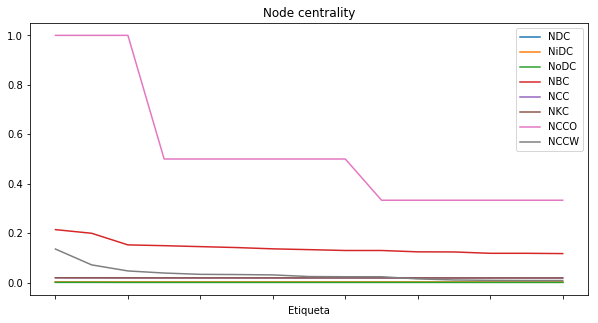

In [41]:
# Data reduction
#fnodes = nodes[hp["plot_node_metrics"]]
fnodes = nodes[['NDC','NiDC','NoDC','NBC','NCC','NKC','NCCO','NCCW']]
fnodes = fnodes.apply(lambda x: x.sort_values(ascending=False).values)
fig, ax = subplots()
fnodes[0:15].plot(ax=ax, title="Node centrality", figsize=(10,5))
#ax.legend(["AAA", "BBB"]);

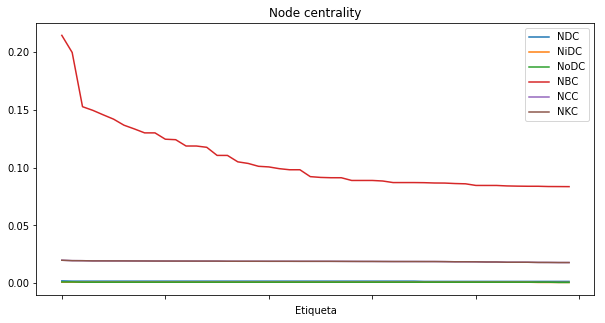

In [29]:
# Data reduction
#fnodes = nodes[hp["plot_node_metrics"]]
fnodes = nodes[['NDC','NiDC','NoDC','NBC','NCC','NKC']]
fnodes = fnodes.apply(lambda x: x.sort_values(ascending=False).values)
fig, ax = subplots()
fnodes[0:50].plot(ax=ax, title="Node centrality", figsize=(10,5))
#ax.legend(["AAA", "BBB"]);

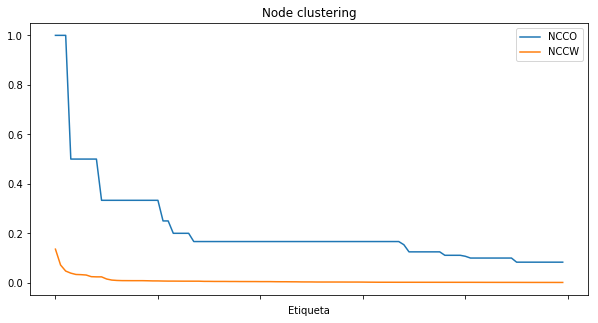

In [36]:
# Clustering Coefficients
cnodes = nodes[['NCCO','NCCW']]
cnodes = cnodes.apply(lambda x: x.sort_values(ascending=False).values)
cnodes[:100].plot( title="Node clustering", figsize=(10,5))

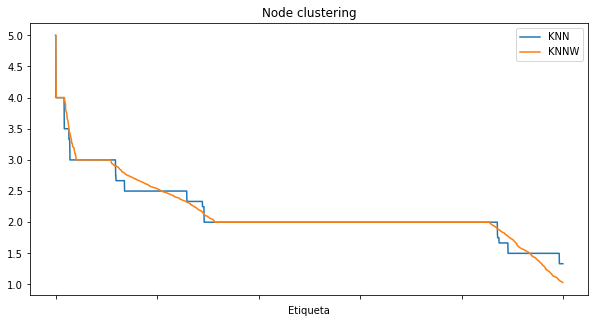

In [38]:
# nearest-neighbors degree
cnodes = nodes[['KNN','KNNW']]
cnodes = cnodes.apply(lambda x: x.sort_values(ascending=False).values)
cnodes[:2500].plot( title="Node clustering", figsize=(10,5))

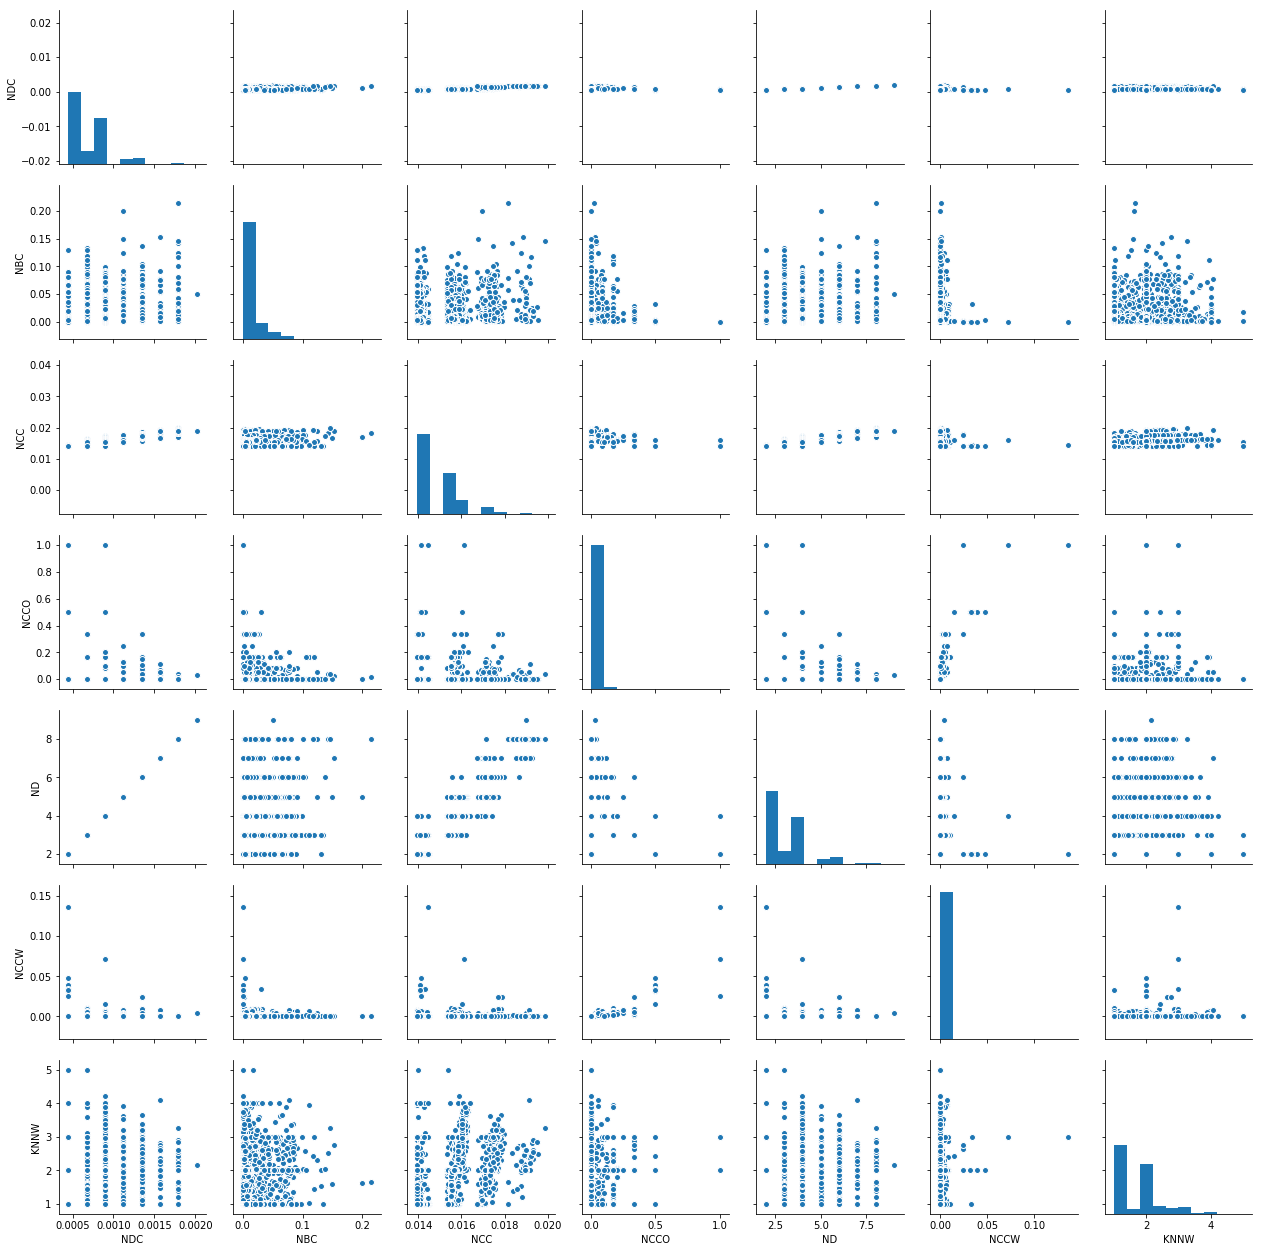

In [42]:
rnodes = nodes[['NDC','NBC','NCC','NCCO','ND','NCCW','KNNW']]
#rnodes = nodes[['NiDC','NoDC','NBC','NCC','NKC','NCCO','NCCW','KNNW']]
sns.pairplot(rnodes)

#### <a name="TVM_VZ">6.3 <span style="color:blue">Dimensionality reduction.</span></a>

We analyze node similarity/disimilarity by applying T-SNE, a dimensionality reduction tecnique that maintains geometrical properties.

In [6]:
# nodes = nodes[hp["plot_node_metrics"]]
nodes = nodes[['ND','NDC','NBC','NCC','NLRC','NKC','NCCO','NCCW','KNNW']]

In [7]:
num_dimensions = 2

# reduce using t-SNE
tsne = TSNE(n_components=num_dimensions, random_state=10, perplexity=30)
vectors = tsne.fit_transform(nodes)

In [8]:
labels = nodes.index.tolist()

In [9]:
x_vals = [v[0] for v in vectors]
y_vals = [v[1] for v in vectors]
#z_vals = [v[2] for v in vectors]

# Create a trace
trace = go.Scatter(
    x=x_vals,
    y=y_vals,
   # z=z_vals,
    mode='text',
    text=labels
    )

data = [trace]
init_notebook_mode(connected=True)
iplot(data, filename='word-embedding-plot')

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-mfxt{background-color:#ffffff;border-color:inherit;text-align:left;vertical-align:middle}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-mfxt"><center><img src="img/tijuana_nodes_p10.png" width="200" height="40" alt="Perplexity 5"><span style="color:blue">Perplexity 10</span></center></th>
    <th class="tg-0pky"><center><img src="img/tijuana_nodes_p30.png" width="200" height="40" alt="Perplexity 30"><span style="color:blue">Perplexity 30</span></center></th>
    <th class="tg-0pky"><center><img src="img/tijuana_nodes_p50.png"width="200" height="40" alt="Perplexity 50"><span style="color:blue">Perplexity 50</span></center></th>
  </tr>
</table>

Perpexity defines how to balance attention between local and global aspects of the data. The parameter is, in a sense, a guess about the number of close neighbors each point has. Tipical values are in the range of 5 to 50. Perplexity for the later image was 30. For clusters with perperxity 30 and 50 the clusters look equidistant. Cluster points are contained. Glpabl conectivity decrease as perperxity values increase.

In [21]:
# Store TSNE vectors to persistance
pvectors = pd.DataFrame(vectors)
pvectors.to_csv(hp["persistance"]["node_tsne"], index=True,  encoding="ISO-8859-1")

#### <a name="TVM_VZ">6.4 <span style="color:blue">Node clustering with HDBSCAN.</span></a>

For location extraction.

In [45]:
# Load TSNE vectors from persistance
vectors = pd.read_csv(hp["persistance"]["node_tsne"],  keep_default_na=False, sep=",", index_col=0, encoding ="ISO-8859-1", engine='python')
vectors = vectors.values       # DataFrame to numpy

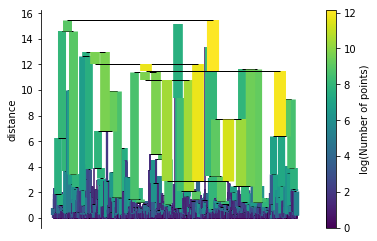

In [46]:
clusterer = hdbscan.RobustSingleLinkage(cut=0.125, k=8)
cluster_labels = clusterer.fit_predict(vectors)
hierarchy = clusterer.cluster_hierarchy_
alt_labels = hierarchy.get_clusters(0.100, 22)
hierarchy.plot()

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-mfxt{background-color:#ffffff;border-color:inherit;text-align:left;vertical-align:middle}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-mfxt"><center><img src="img/cluster_nodes_2D_k2.png" width="300" height="50" alt="Perplexity 5"><span style="color:blue">2D nodes k2</span></center></th>
    <th class="tg-0pky"><center><img src="img/cluster_nodes_2D_k4.png" width="300" height="50" alt="Perplexity 30"><span style="color:blue">2D nodes k4</span></center></th>
    <th class="tg-0pky"><center><img src="img/cluster_nodes_2D_k8.png"width="300" height="50" alt="Perplexity 50"><span style="color:blue">2D nodes k8</span></center></th>
  </tr>
</table>


Ahora, es necesario identificar que vertices pertenecen a que grupo. Después, que trayectoria pertenece en almenos un umbral a una agrupacion. Las trayectorias resultantes, seran agregadas a una matriz por grupo. Esta sera visualizada aplicando los otros métodos de visualizacion.

In [47]:
pdf = pd.DataFrame(columns=['Label', 'Cluster','Size'])
for label in np.unique(cluster_labels):
    cluster = np.where(cluster_labels == label)
    pdf = pdf.append({'Label' : label , 'Cluster' : cluster[0],
                       'Size' : len(cluster[0])} , ignore_index=True)

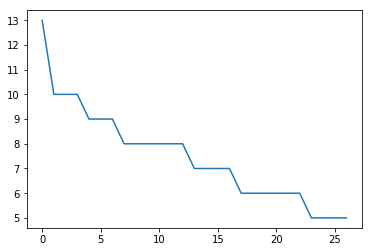

In [48]:
pdk = pdf.sort_values(by=['Size'],ascending=False)
plt.plot(pdk.Size[1:].values)

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-mfxt{background-color:#ffffff;border-color:inherit;text-align:left;vertical-align:middle}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-mfxt"><center><img src="img/node_clusters_sim_2D_k2.png" width="300" height="50" alt="Perplexity 5"><span style="color:blue">2D nodes k2</span></center></th>
    <th class="tg-0pky"><center><img src="img/node_clusters_sim_2D_k4.png" width="300" height="50" alt="Perplexity 30"><span style="color:blue">2D nodes k4</span></center></th>
    <th class="tg-0pky"><center><img src="img/node_clusters_sim_2D_k8.png"width="300" height="50" alt="Perplexity 50"><span style="color:blue">2D nodes k8</span></center></th>
  </tr>
</table>

In [51]:
# Store clusters to persistance
pdk.to_csv(hp["persistance"]["node_clusters"], index=True,  encoding="ISO-8859-1")

In [52]:
# Loas clusters from persistance
clusters = pd.read_csv(hp["persistance"]["node_clusters"],  keep_default_na=False, sep=",", index_col=0, encoding ="ISO-8859-1", engine='python')

#### <a name="TVM_VZ">6.5 <span style="color:blue">Rendering clustered points.</span></a>


In [ ]:
plt.figure(figsize=(60,30))

plt.title('Tijuana map: 8 regions.', fontsize=70)

map = Basemap(llcrnrlon=-117.13,llcrnrlat=32.36, urcrnrlon=-116.65,urcrnrlat=32.58,resolution = 'h')

#atributos de mapa
map.drawcoastlines()
map.drawcountries()
map.drawstates()
#map.drawmapboundary(fill_color='aqua') 
#map.fillcontinents(color='#cc9955')  #one of {'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'};

#ejemplo de puntos en mapa
lat,lon=32.50222437574,-116.8607274597  #V0, ND=7
x, y = map(lon,lat)
map.plot(x,y, marker='D', markersize=10,color='m')

lat,lon=32.47567658184,-116.87321140081  #V347, ND=9
x, y = map(lon,lat)
map.plot(x,y, marker='X', markersize=15,color='b')

lat,lon=32.4748011382,-116.86019059706  #V2070, ND=9
x, y = map(lon,lat)
map.plot(x,y, marker='*',markersize=15,color='r')

lat,lon=32.50062317011,-116.854501964  #V5, ND=8
x, y = map(lon,lat)
map.plot(x,y, marker='.',markersize=20,color='aqua') #marker= '.', '*', 'D', '+', 'x', ...


#importa poligonos
import_region =map.readshapefile(r"C:\Users\Belgica\Documents\Research\My stuff\Grafos\OpenStreetMap\shapefile\Delegaciones\Delegaciones-polygon", "Delegaciones-polygon", color='k',linewidth=5)

#importa mapa de Esri  
#http://server.arcgisonline.com/arcgis/rest/services
map.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 15000, verbose= True)

#texto en mapa
lat, lon= 32.4499029,-117.085669
x, y=map(lon,lat)
plt.text(x,y,'1',fontsize=40,fontweight='bold',
         ha='left',va='center',color='k', bbox=dict(facecolor='aqua', alpha=0.5)) 
            # bbox=dict(facecolor='tab:pink', alpha=0.2) alpha es intensidad del color
                                                                            
lat, lon= 32.4652866, -117.0390299
x, y=map(lon,lat)
plt.text(x,y,'2',fontsize=40,fontweight='bold', ha='left',va='center',color='k', bbox=dict(facecolor='aqua', alpha=0.5))

lat, lon= 32.5158687,-117.0269895  
x, y=map(lon,lat)
plt.text(x,y,'3',fontsize=40,fontweight='bold', ha='left',va='center',color='k', bbox=dict(facecolor='aqua', alpha=0.5))

lat, lon= 32.4545541, -116.9665274
x, y=map(lon,lat)
plt.text(x,y,'4',fontsize=40,fontweight='bold', ha='left',va='center',color='k', bbox=dict(facecolor='aqua', alpha=0.5))

lat, lon= 32.53719, -116.9409228
x, y=map(lon,lat)
plt.text(x,y,'5',fontsize=40,fontweight='bold', ha='left',va='center',color='k', bbox=dict(facecolor='aqua', alpha=0.5))

plt.show()

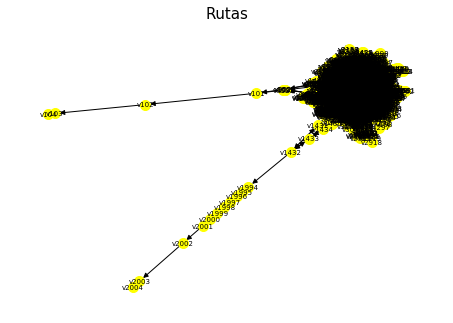

In [6]:
# Graph visualization
nx.draw(G, **options)
plt.title("Rutas",size=15)
plt.savefig("fig.png")
plt.show()

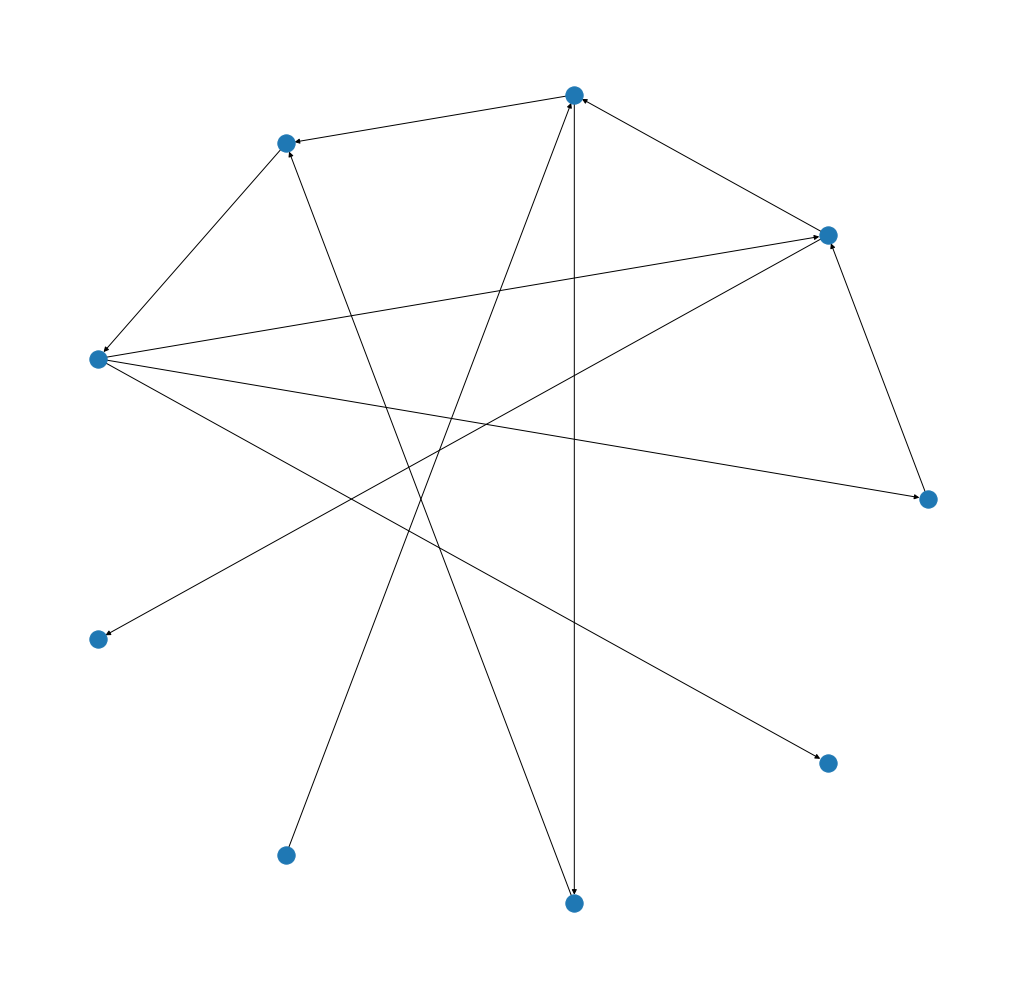

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(18, 18))
nx.draw_circular(G, ax=ax)

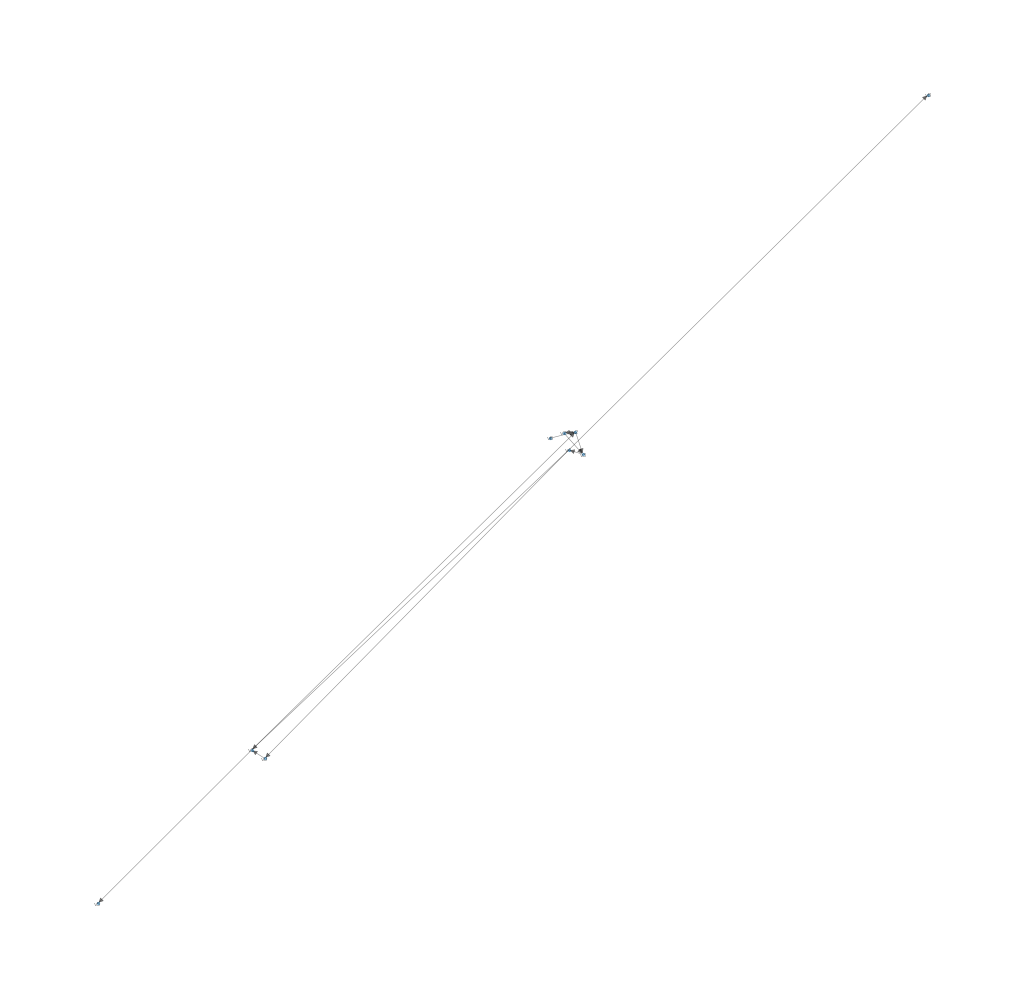

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(18, 18))
nx.draw_networkx(G, ax=ax, node_size=5,
                 font_size=6, alpha=.5,
                 width=.5)
ax.set_axis_off()

In [99]:
sgs = list(nx.connected_component_subgraphs(
    G.to_undirected()))
i = np.argmax([len(sg) for sg in sgs])
sg = sgs[i]
len(sg)

9

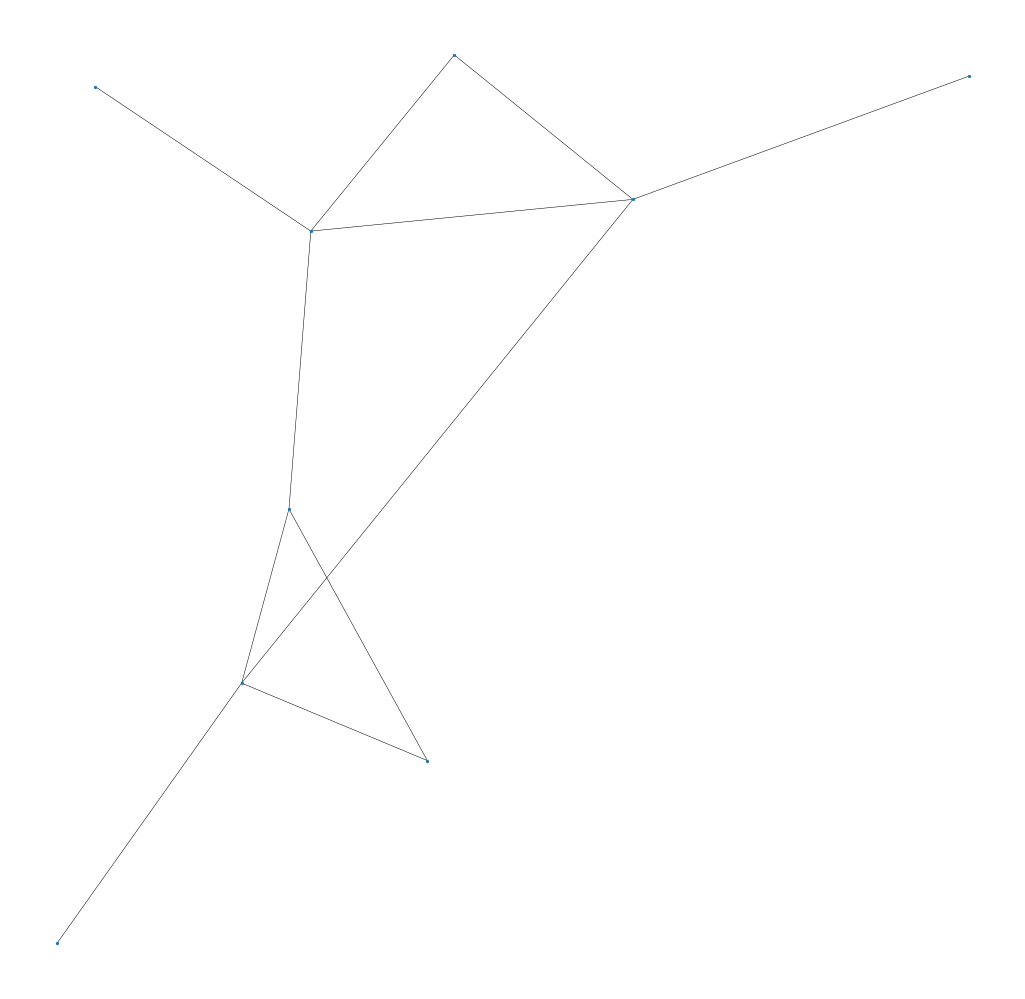

In [100]:
sg = next(nx.connected_component_subgraphs(G.to_undirected()))
fig, ax = plt.subplots(1, 1, figsize=(18, 18))
nx.draw_networkx(sg, ax=ax, with_labels=False,
                 node_size=5, width=.5)
ax.set_axis_off()

In [101]:
nodes = [{'node':str(i)[1:]} for i in G.nodes()]
links = [{'source':int(u[0][1:]),'target':int(u[1][1:])} for u in G.edges()]

isualizacion con D3

In [102]:
#nodes = [{'name': str(i), 'club': g.node[i]['club']}
#         for i in g.nodes()]
#links = [{'source': u[0], 'target': u[1]}
#         for u in g.edges()]
with open(r"6dag.json", 'w') as f:
    json.dump({'nodes': nodes, 'links': links},
              f, indent=4,)

In [103]:
%%html
<div id="d3-example"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

In [104]:
%%javascript
// We load the d3.js library from the Web.
require.config({paths:
    {d3: "http://d3js.org/d3.v3.min"}});
require(["d3"], function(d3) {
  // The code in this block is executed when the
  // d3.js library has been loaded.

  // First, we specify the size of the canvas
  // containing the visualization (size of the
  // <div> element).
  var width = 700, height = 700;

  // We create a color scale.
  var color = d3.scale.category10();

  // We create a force-directed dynamic graph layout.
  var force = d3.layout.force()
    .charge(-120)
    .linkDistance(30)
    .size([width, height]);

  // In the <div> element, we create a <svg> graphic
  // that will contain our interactive visualization.
  var svg = d3.select("#d3-example").select("svg")
  if (svg.empty()) {
    svg = d3.select("#d3-example").append("svg")
          .attr("width", width)
          .attr("height", height);
  }

  // We load the JSON file.
  d3.json("6dag.json", function(error, graph) {
    // In this block, the file has been loaded
    // and the 'graph' object contains our graph.

    // We load the nodes and links in the
    // force-directed graph.
    force.nodes(graph.nodes)
      .links(graph.links)
      .start();

    // We create a <line> SVG element for each link
    // in the graph.
    var link = svg.selectAll(".link")
      .data(graph.links)
      .enter().append("line")
      .attr("class", "link");

    // We create a <circle> SVG element for each node
    // in the graph, and we specify a few attributes.
    var node = svg.selectAll(".node")
      .data(graph.nodes)
      .enter().append("circle")
      .attr("class", "node")
      .attr("r", 5)  // radius
      .style("fill", function(d) {
         // The node color depends on the club.
         return color(d.club);
      })
      .call(force.drag);

    // The name of each node is the node number.
    node.append("title")
        .text(function(d) { return d.name; });

    // We bind the positions of the SVG elements
    // to the positions of the dynamic force-directed
    // graph, at each time step.
    force.on("tick", function() {
      link.attr("x1", function(d){return d.source.x})
          .attr("y1", function(d){return d.source.y})
          .attr("x2", function(d){return d.target.x})
          .attr("y2", function(d){return d.target.y});

      node.attr("cx", function(d){return d.x})
          .attr("cy", function(d){return d.y});
    });
  });
});

<IPython.core.display.Javascript object>

### <a name="TVM_SDT">6. <span style="color:blue">Statistical data analysis</span></a> 

In [15]:
# Load from persistance
nodes = pd.read_csv(hp["persistance"]["nodes"],  keep_default_na=False, sep=",", index_col=0, encoding ="ISO-8859-1", engine='python')
edges = pd.read_csv(hp["persistance"]["edges"],  keep_default_na=False, sep=",",  index_col=0, encoding ="ISO-8859-1", engine='python')
G = nx.read_gpickle(hp["persistance"]["dag"])

#### <span style="color:blue">Global DAG properties</span>

In [16]:
global_properties = pd.DataFrame(columns=['Label', 'Cluster','Size'])
nx.global_reaching_centrality(G)


0.004274201196962498

#### <span style="color:blue">Node properties </span>

In [6]:
# Data reduction
#nodes = nodes[hp["plot_node_metrics"]]
nodes = nodes[['NDC','NBC','NCC','NKC','NiDC','NoDC']]
nodes = nodes.apply(lambda x: x.sort_values(ascending=False).values)

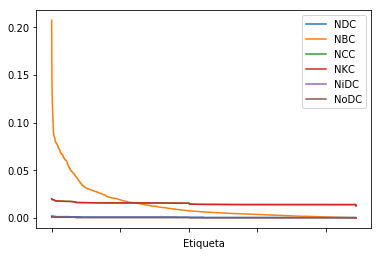

In [7]:
# Statistical analysis
nodes.plot()

In [61]:
# First order statistics
nodes.describe()

,NDC,NBC,NCC,NKC,NLRC,NiDC,NoDC
count,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000
mean,0.000695,0.013890,0.014966,0.014966,0.995727,0.000347,0.000347
std,0.000290,0.018995,0.001139,0.001139,0.055961,0.000151,0.000151
min,0.000225,0.000000,0.012595,0.012595,0.000000,0.000000,0.000000
25%,0.000451,0.002674,0.013994,0.013994,0.998873,0.000225,0.000225
50%,0.000451,0.006277,0.014170,0.014170,0.998873,0.000225,0.000225
75%,0.000901,0.016924,0.015743,0.015743,0.998873,0.000451,0.000451
max,0.002028,0.207409,0.019941,0.019941,1.000000,0.000901,0.001127


In [64]:
G.number_of_nodes()
# G.number_of_edges()

4439

**Experimental setup**

We use t-SNE to convert the 6 dimensional data to a two-dimensional map. All datapoints are labeled with the name of the vertex, but the label is not used for clustering purposes. 



In [9]:
num_dimensions = 2

# reduce using t-SNE
tsne = TSNE(n_components=num_dimensions, random_state=10, perplexity=30)
vectors = tsne.fit_transform(nodes)

ValueError: could not convert string to float: '32.50222437574:-116.8607274597'

In [20]:
labels = nodes.index.tolist()

In [24]:
x_vals = [v[0] for v in vectors]
y_vals = [v[1] for v in vectors]
#z_vals = [v[2] for v in vectors]

# Create a trace
trace = go.Scatter(
    x=x_vals,
    y=y_vals,
   # z=z_vals,
    mode='text',
    text=labels
    )

data = [trace]
init_notebook_mode(connected=True)
iplot(data, filename='word-embedding-plot')

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-mfxt{background-color:#ffffff;border-color:inherit;text-align:left;vertical-align:middle}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-mfxt"><center><img src="img/tijuana_nodes_p10.png" width="200" height="40" alt="Perplexity 5"><span style="color:blue">Perplexity 10</span></center></th>
    <th class="tg-0pky"><center><img src="img/tijuana_nodes_p30.png" width="200" height="40" alt="Perplexity 30"><span style="color:blue">Perplexity 30</span></center></th>
    <th class="tg-0pky"><center><img src="img/tijuana_nodes_p50.png"width="200" height="40" alt="Perplexity 50"><span style="color:blue">Perplexity 50</span></center></th>
  </tr>
</table>

Perpexity defines how to balance attention between local and global aspects of the data. The parameter is, in a sense, a guess about the number of close neighbors each point has. Tipical values are in the range of 5 to 50. Perplexity for the later image was 30. For clusters with perperxity 30 and 50 the clusters look equidistant. Cluster points are contained. Glpabl conectivity decrease as perperxity values increase.

Perpexity defines how to balance attention between local and global aspects of the data. The parameter is, in a sense, a guess about the number of close neighbors each point has. Tipical values are in the range of 5 to 50. Perplexity for the later image was 30. For clusters with perperxity 30 and 50 the clusters look equidistant. Cluster points are contained. Glpabl conectivity decrease as perperxity values increase.

### Clusterizacion

In [9]:
# min_samples = 17
clustering = DBSCAN(eps=0.7,  min_samples = 5,  metric='cityblock').fit(nodes)

In [11]:
np.unique(clustering.labels_)

array([0], dtype=int64)

In [8]:
import hdbscan
from sklearn.datasets import make_blobs

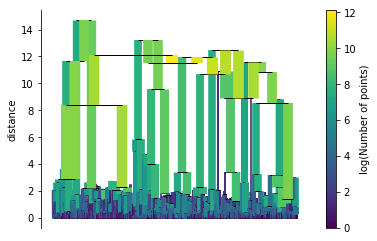

In [87]:
clusterer = hdbscan.RobustSingleLinkage(cut=0.125, k=8)
cluster_labels = clusterer.fit_predict(vectors)
hierarchy = clusterer.cluster_hierarchy_
alt_labels = hierarchy.get_clusters(0.100, 22)
hierarchy.plot()

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-mfxt{background-color:#ffffff;border-color:inherit;text-align:left;vertical-align:middle}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-mfxt"><center><img src="img/cluster_nodes_2D_k2_22.png" width="300" height="50" alt="Perplexity 5"><span style="color:blue">2D nodes k2 C22</span></center></th>
    <th class="tg-0pky"><center><img src="img/cluster_nodes_2D_k4_22.png" width="300" height="50" alt="Perplexity 30"><span style="color:blue">2D nodes k4 C22</span></center></th>
    <th class="tg-0pky"><center><img src="img/cluster_nodes_2D_k8_22.png"width="300" height="50" alt="Perplexity 50"><span style="color:blue">2D nodes k4 C22</span></center></th>
  </tr>
</table>

Ahora, es necesario identificar que vertices pertenecen a que grupo. Después, que trayectoria pertenece en almenos un umbral a una agrupacion. Las trayectorias resultantes, seran agregadas a una matriz por grupo. Esta sera visualizada aplicando los otros métodos de visualizacion.

In [88]:
pdf = pd.DataFrame(columns=['Label', 'Cluster','Size'])
for label in np.unique(cluster_labels):
    cluster = np.where(cluster_labels == label)
    pdf = pdf.append({'Label' : label , 'Cluster' : cluster[0],
                       'Size' : len(cluster[0])} , ignore_index=True)

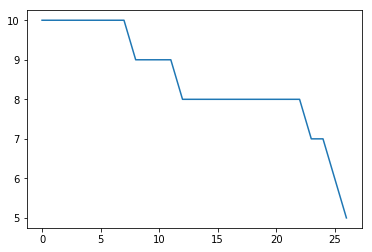

In [89]:
pdk = pdf.sort_values(by=['Size'],ascending=False)
plt.plot(pdk.Size[1:].values)

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-mfxt{background-color:#ffffff;border-color:inherit;text-align:left;vertical-align:middle}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-mfxt"><center><img src="img/node_clusters_sim_2D_k2_22.png" width="300" height="50" alt="Perplexity 5"><span style="color:blue">2D nodes k2 C22</span></center></th>
    <th class="tg-0pky"><center><img src="img/node_clusters_sim_2D_k4_22.png" width="300" height="50" alt="Perplexity 30"><span style="color:blue">2D nodes k4 C22</span></center></th>
    <th class="tg-0pky"><center><img src="img/node_clusters_sim_2D_k8_22.png"width="300" height="50" alt="Perplexity 50"><span style="color:blue">2D nodes k8 C22</span></center></th>
  </tr>
</table>

In [1]:
from mpl_toolkits.basemap import Basemap 
import matplotlib.pyplot as plt

map = Basemap(llcrnrlat=31,urcrnrlat=33,llcrnrlon=-117.7,urcrnrlon=-114.7,resolution = 'h')
map.drawcoastlines()
map.drawcountries()
map.drawstates()
map.drawmapboundary(fill_color='aqua') 
map.fillcontinents(color='#ddaa66', lake_color='aqua') 

lat,lon=32.50222437574,-116.8607274597 #es posible cargar mas puntos
x, y = map(lon,lat)
map.plot(x,y, marker='D',color='g') 

plt.title('Tijuana map')

plt.show()

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

### <a name="TVM_LIB">8. <span style="color:blue">References</span></a>

1. Gil, J. Y. & Kimmel, R.Efficient dilation, erosion, opening, and closing algorithms IEEE Transactions on Pattern Analysis and Machine Intelligence, 2002 , 24 , 1606-1617
2. Jackway, P. T. & Deriche, M. Scale-space properties of the multiscale morphological dilation-erosion IEEE Transactions on Pattern Analysis and Machine Intelligence, 1996, 18, 38-51 
3. Lin, J. & Ban, Y. Comparative Analysis on Topological Structures of Urban Street Networks. ISPRS Int. J. Geo-Information, 2017 , 6 , 295
4. Lin, J. Spatial analysis and modeling of urban transportation networks KTH, Geoinformatics, KTH, Geoinformatics, 2017 , 77.
5. Barthélemy, M. Spatial networks. Physics Reports, Elsevier BV, 2011 , 499 , 1-101 
6. Newman, M. E. J. Networks: An Introduction. Oxford University Press, 2010
7. Rodrigue, J.-P. The Geography of Transport Systems. Routledge, 2013    
8. Cardozo, O. D.; Erica Leonor, G. & Miguel Alejandro, P. Teoría de grafos y sistemas de información geográfica aplicados al transporte público de pasajeros en resistencia (Argentina). Revista Transporte y Territorio, 2009 , 89-111 
9. Jiang, B. & Claramunt, C. Topological Analysis of Urban Street Networks. Environment and Planning B: Planning and Design, SAGE Publications, 2004 , 31 , 151-162
10. Scheurer, J.; Curtis, C. & Porta, S. Spatial network analysis of public transport systems : developing a strategic planning tool to assess the congruence of movement and urban structure in Australian cities Australasian Transport Research Forum, Australasian Transport Research Forum, 2007 
11. Sevtsuk, A. & Mekonnen, M. Urban network analysis. A new toolbox for ArcGIS. Revue internationale de géomatique, Lavoisier, 2012 , 22 , 287-305
12. Viana, M. P.; Strano, E.; Bordin, P. & Barthelemy, M. The simplicity of planar networks. Scientific Reports, Springer Science and Business Media LLC, 2013 , 3
13. Harris, J.; Hirst, J. L. & Mossinghoff, M. Combinatorics and Graph Theory. Springer New York, 2008
14. Kirkley, A.; Barbosa, H.; Barthelemy, M. & Ghoshal, G.From the betweenness centrality in street networks to structural invariants in random planar graphs. Nature Communications, Springer Nature, 2018 , 9
15. Kansky, K. & Danscoine, P. Measures of network structure. Flux, PERSEE Program, 1989 , 5 , 89-121
16. Porta, S.; Crucitti, P. & Latora, V. The Network Analysis of Urban Streets: A Primal Approach. Environment and Planning B: Planning and Design, SAGE Publications, 2006 , 33 , 705-725
17. Rodrigue, J.-P.; Comtois, C. & Slack, B. The geography of transport systems, 2017 
18. Barrat, A.; Barthelemy, M.; Pastor-Satorras, R. & Vespignani, A. The architecture of complex weighted networks. Proceedings of the National Academy of Sciences, Proceedings of the National Academy of Sciences, 2004 , 101 , 3747-3752
19. Lin, J. & Ban, Y. Complex Network Topology of Transportation Systems Transport Reviews, Routledge, 2013 , 33 , 658-685 
20. Mones, E.; Vicsek, L. & Vicsek, T. Boccaletti, S. (Ed.). Hierarchy Measure for Complex Networks. PLoS ONE, Public Library of Science (PLoS), 2012 , 7 , e33799
21. Saramäki, J.; Kivelä, M.; Onnela, J.-P.; Kaski, K. & Kertész, J. Generalizations of the clustering coefficient to weighted complex networks. Physical Review E, American Physical Society (APS), 2007 , 75
22. Fagiolo, G. Clustering in complex directed networks. Physical Review E, American Physical Society (APS), 2007 , 76
23. Schank, T. & Wagner, D. Approximating Clustering Coefficient and Transitivity. Journal of Graph Algorithms and Applications, 2005 , 9 , 265-275
24. Opsahl, T. & Panzarasa, P. Clustering in weighted networks. Social Networks, Elsevier BV, 2009 , 31 , 155-163

In [ ]:
TODO: Codigo requerido para extraccion de rutas en poligonos.
        
        
        import matplotlib.pyplot as plt
import numpy as np

first = -3
size  = (3-first)/100
xv,yv = np.meshgrid(np.linspace(-3,3,100),np.linspace(-3,3,100))
p = path.Path([(0,0), (0, 1), (1, 1), (1, 0)])  # square with legs length 1 and bottom left corner at the origin
flags = p.contains_points(np.hstack((xv.flatten()[:,np.newaxis],yv.flatten()[:,np.newaxis])))
grid = np.zeros((101,101),dtype='bool')
grid[((xv.flatten()-first)/size).astype('int'),((yv.flatten()-first)/size).astype('int')] = flags

xi,yi = np.random.randint(-300,300,100)/100,np.random.randint(-300,300,100)/100
vflag = grid[((xi-first)/size).astype('int'),((yi-first)/size).astype('int')]
plt.imshow(grid.T,origin='lower',interpolation='nearest',cmap='binary')
plt.scatter(((xi-first)/size).astype('int'),((yi-first)/size).astype('int'),c=vflag,cmap='Greens',s=90)
plt.show()